In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch
from Models.models import NNdynamic, plot_confusion_matrix, plot_metrics
import shap
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [2]:
data = pd.read_csv('Cleaned_full_data.csv')

C:\Users\adi_s\AppData\Local\Temp\ipykernel_34116\2584280520.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Cleaned_full_data.csv')


In [3]:
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')

In [4]:
data = data.drop(columns=['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])

In [5]:
temp = data[['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat']]
data = data.drop(columns=['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat'])

In [6]:
# The resulting encoded features can be found in Tools/EncoderTests.
ohe1 = pd.read_csv('Full_proto_encoded.csv')
ohe2 = pd.read_csv('Full_dsport_encoded.csv')
ohe3 = pd.read_csv('Full_service_encoded.csv')
ohe4 = pd.read_csv('Full_state_encoded.csv')
# Spelling error.
ohe5 = pd.read_csv('Full_scrip_encoded.csv')
#------------------------------------------#
ohe6 = pd.read_csv('Full_sport_encoded.csv')
ohe7 = pd.read_csv('Full_dstip_encoded.csv')

In [7]:
# MinMax seperates Normal data well and reduces noise. Please see Kmeans TSNE evaluation in Tools.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, columns=data.columns)
data = pd.concat([data, temp, ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)

In [8]:
data = data.sample(n=10000)

In [9]:
X_temp = data.drop(columns=['label'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y, test_size=0.2, random_state=42)
test_attack_cat = X_test['attack_cat']
print('Train:', y_train.value_counts())
print('Test', y_test.value_counts())
X_train = X_train.drop(columns=['attack_cat'])
X_test = X_test.drop(columns=['attack_cat'])

Train: label
0    6975
1    1025
Name: count, dtype: int64
Test label
0    1766
1     234
Name: count, dtype: int64


In [10]:
# Prepare batches.
batch_size = 128
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_train_tensor.shape[1]
fc_size = 128
save_dir = './Models/saved_models/'
model1 = NNdynamic(n_features, fc_size, device, save_dir)

Epoch 1/5: 100%|██████████| 63/63 [00:00<00:00, 146.45batch/s]


Epoch [1/5], Train Loss: 0.0960, Train Acc: 0.9680, Train F1: 0.9600


Epoch 2/5: 100%|██████████| 63/63 [00:00<00:00, 176.78batch/s]


Epoch [2/5], Train Loss: 0.0214, Train Acc: 0.9895, Train F1: 0.9893


Epoch 3/5: 100%|██████████| 63/63 [00:00<00:00, 162.04batch/s]


Epoch [3/5], Train Loss: 0.0192, Train Acc: 0.9907, Train F1: 0.9906


Epoch 4/5: 100%|██████████| 63/63 [00:00<00:00, 174.94batch/s]


Epoch [4/5], Train Loss: 0.0173, Train Acc: 0.9914, Train F1: 0.9914


Epoch 5/5: 100%|██████████| 63/63 [00:00<00:00, 197.66batch/s]


Epoch [5/5], Train Loss: 0.0174, Train Acc: 0.9914, Train F1: 0.9914


Testing: 100%|██████████| 16/16 [00:00<00:00, 340.68batch/s]


Test Loss: 0.0210, Test Accuracy: 0.9881, Test F1: 0.9885


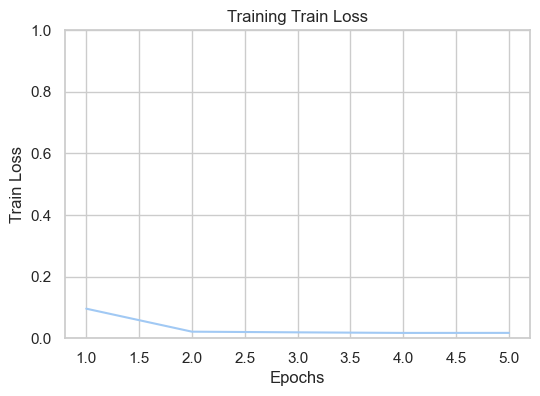

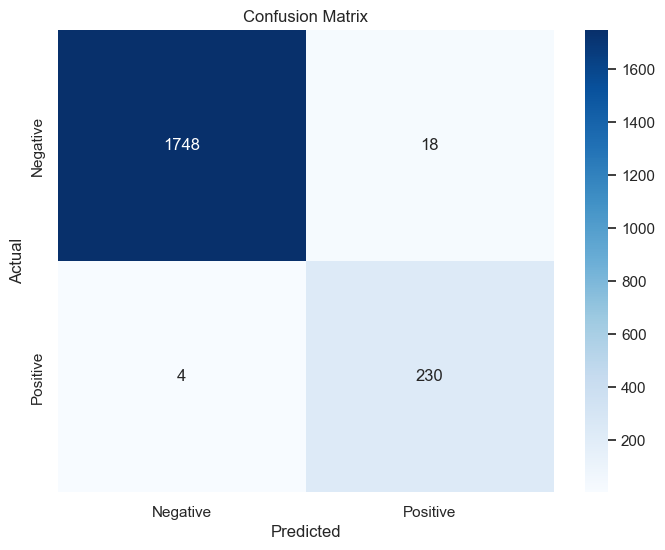

In [13]:
sampler = None
params = None
learning_rate = 0.01
epochs = 5
save_factor = 100
store_data = False
model1.run(train_loader, learning_rate, epochs, save_factor, sampler, params, store_data)
model1.test(test_loader)
plot_metrics(model1.train_loss, len(model1.train_loss), title="Train Loss")
labels = test_dataset.tensors[1]
plot_confusion_matrix(labels, model1.test_predicted)

In [35]:
X_background = torch.tensor(X_train.iloc[:, :10].values, dtype=torch.float32)

In [31]:
print(len(X_train.columns))
print(len(X_train.iloc[:, :10].columns))

322
10


# I probably need to spend some time on the visualisations then develop this further.

In [ ]:
class SHAPselector:
    def __init__(self, data):
        self.background = data
        self.shap_data = None
        self.tensor = None
        self.actual = None
        self.predicted = None
        self.background_data = None
        self.background_tensor = None

    def add_labels(self, type_of, labels):
        
        if type_of == 'predicted':
            self.predicted = labels
        if type_of == 'actual':
            self.actual = labels


    def sample_background(self, size, rs):
        bk = data.sample(n=size, random_state=rs)
        static_columns = bk.columns[bk.nunique() == 1].tolist()
        if static_columns:
            print('Warning. Static variables in background sample may not truly represent the data')
            for col in static_columns:
                print(f"{col}")
        else:
            print('No static variables in sample')
        self.background_data = bk

    
    






In [27]:
ss = SHAPselector(X_train, X_test)

In [25]:
ss.sample_background(1000, 42)

Warning. Static variables in background sample may not truly represent the data
proto_icmp
proto_any
proto_gre
proto_rsvp
proto_ipv6
proto_swipe
proto_sun-nd
proto_pim
proto_mobile
proto_sep
proto_micp
proto_aes-sp3-d
proto_encap
proto_eigrp
proto_ipip
proto_mtp
proto_larp
proto_sprite-rpc
proto_pri-enc
proto_etherip
proto_vmtp
proto_tcf
proto_dgp
proto_nsfnet-igp
proto_ttp
proto_vines
proto_pnni
proto_secure-vmtp
proto_iso-ip
proto_wb-expak
proto_wb-mon
proto_br-sat-mon
proto_pvp
proto_wsn
proto_gmtp
proto_scps
proto_ifmp
proto_stp
proto_fc
proto_iplt
proto_pipe
proto_sps
proto_sccopmce
proto_crudp
proto_isis
proto_crtp
proto_fire
proto_ptp
proto_sm
proto_uti
proto_smp
proto_srp
proto_aris
proto_l2tp
proto_ddx
proto_pgm
proto_zero
proto_vrrp
proto_ipx-n-ip
proto_compaq-peer
proto_ipcomp
proto_snp
proto_cpnx
proto_a/n
proto_qnx
proto_cphb
proto_cftp
proto_visa
proto_netblt
proto_rdp
proto_irtp
proto_leaf-2
proto_leaf-1
proto_trunk-2
proto_xns-idp
proto_trunk-1
proto_prm
proto_dcn
proto